<a href="https://colab.research.google.com/github/frosinastojanovska/predoc-course-2020/blob/main/nuclei_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To work with the notebook, the Drive needs to be mounted. Additionally, there should be a folder named qbm_data with the following structure:


*   qbm_module
*   |----cell_boundary - sub-folder containing probabilities of the cell boundaries created with the unet from ilastik4ij(ending with the suffix Probaility before the .h5 extension in the name)
*   |----cell_seg - sub-folder (at the begining empty) that contains the predicted segmentations of the celss using the watershed algorithm (saved as tif files)
*   |----nuclei_seg - sub-folder (at the begining empty) that contains the prediction for the nuclei segmentation with tif file for the mask, tif file for the labels, and zip file for RoIs
*   |----raw - sub-folder containing dataset h5 files with the channels
*   |----result_images - sub-folder (at the begining empty) that contains images created lated in the notebook for visualization of the results

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Installation of StarDist

In [ ]:
!pip install stardist

#Start working with StarDist

In [ ]:
from stardist.models import StarDist2D 

# prints a list of available models 
StarDist2D.from_pretrained() 

# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


#Make predictions for nuclei segmentation

In [ ]:
import h5py
import os
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois

filenames = [filename for filename in os.listdir('/content/drive/MyDrive/qbm_data/raw') if filename.endswith(".h5")]

for filename in filenames:
    with h5py.File('/content/drive/MyDrive/qbm_data/raw/' + filename, "r") as f:
        serum_image = f.get('raw').value[0,::]
        nuclei_image = f.get('raw').value[2,::]
        axis_norm = (0,1)
        img_norm = normalize(nuclei_image, 1,99.8, axis=axis_norm)
        gt_segmentation = f.get('infected').value
        labels, details = model.predict_instances(img_norm) 
        # Save predictions
        save_tiff_imagej_compatible('/content/drive/MyDrive/qbm_data/nuclei_seg/' + filename.split('.h5')[0] + '_image.tif', nuclei_image, axes='YX')
        save_tiff_imagej_compatible('/content/drive/MyDrive/qbm_data/nuclei_seg/' + filename.split('.h5')[0] + '_labels.tif', labels, axes='YX')
        export_imagej_rois('/content/drive/MyDrive/qbm_data/nuclei_seg/' + filename.split('.h5')[0] + '_rois.zip', details['coord'])  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/csbdeep/io/__init__.py:40: UserWarning: Converting data type from 'int32' to ImageJ-compatible 'int16'.
  warnings.warn("Converting data type from '%s' to ImageJ-compatible '%s'." % (t, np.dtype(t_new)))


## Visualize the predictions

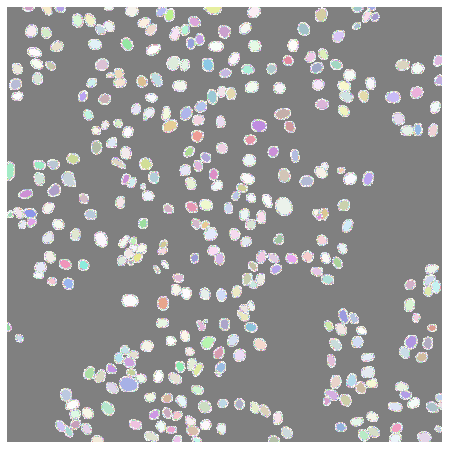

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from csbdeep.io import save_tiff_imagej_compatible
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois

np.random.seed(6)
lbl_cmap = random_label_cmap()

plt.figure(figsize=(8,8))
plt.imshow(nuclei_image if nuclei_image.ndim==2 else nuclei_image[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');

# Watershed

Use the (1) nuclei segmentation predicted with runing the previous code cells and (2) predictions created with ** ilastik4ij** (must be created manually and uploaded into the folder) where the cell boundaries probabilities are stored into the qbm\_module/cell\_boundary folder as h5 files (ending with the suffix Probaility before the .h5 extension in the name). The result with the cell segmentation files are stored in qbm\_module/cell\_seg as tif files (ending with the suffix _cellseg before the .tif extension in the name). 

In [ ]:
! pip  install -U scikit-image

In [ ]:
import h5py
import os
from PIL import Image
from skimage.segmentation import watershed
from csbdeep.io import save_tiff_imagej_compatible
import numpy as np

filenames = [filename for filename in os.listdir('/content/drive/MyDrive/qbm_data/cell_boundary') if filename.endswith("Probabilities.h5")]

for filename in filenames:
    with h5py.File('/content/drive/MyDrive/qbm_data/cell_boundary/' + filename, "r") as f:
        background = f.get('exported_data').value[0,:,:,0]
        background[background < 0.5] = 0
        boundaries = f.get('exported_data').value[0,:,:,1]
        im = Image.open('/content/drive/MyDrive/qbm_data/nuclei_seg/' + filename.split('-')[0] + '_labels.tif')
        labels = np.array(im)
    with h5py.File('/content/drive/MyDrive/qbm_data/raw/' + filename.split('-')[0] + '.h5', "r") as f:
        serum_image = f.get('raw').value[0,::]
    result = watershed(boundaries, markers=labels, mask=background)
    save_tiff_imagej_compatible('/content/drive/MyDrive/qbm_data/cell_seg/' + filename.split('-')[0] + '_cellseg.tif', result, axes='YX')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/csbdeep/io/__init__.py:40: UserWarning: Converting data type from 'int32' to ImageJ-compatible 'int16'.
  warnings.warn("Converting data type from '%s' to ImageJ-compatible '%s'." % (t, np.dtype(t_new)))


##Visualization of the result for the cell segmentation

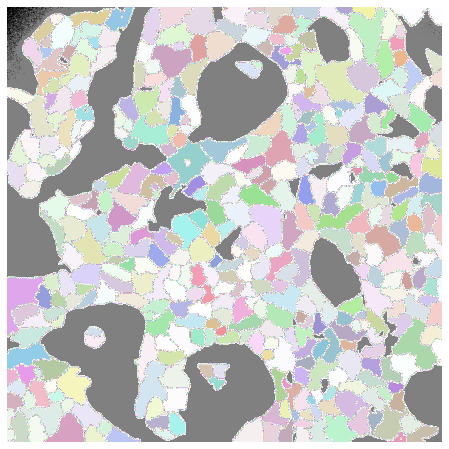

In [ ]:
np.random.seed(6)
lbl_cmap = random_label_cmap()
plt.figure(figsize=(8,8))
plt.imshow(serum_image, clim=(0,1), cmap='gray')

plt.imshow(result, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');

##Jaccard similarity score

In [ ]:
from PIL import Image
import numpy as np
import os
import h5py
from sklearn.metrics import jaccard_similarity_score


filenames = [filename for filename in os.listdir('/content/drive/MyDrive/qbm_data/cell_seg') if filename.endswith("cellseg.tif")]

for filename in filenames:
    with h5py.File('/content/drive/MyDrive/qbm_data/raw/' + filename.split('_cellseg')[0] + '.h5', "r") as f:
        cell_image = f.get('cells').value
        cell_image[cell_image > 0] = 1
    im = Image.open('/content/drive/MyDrive/qbm_data/cell_seg/' + filename)
    cell_seg = np.array(im)
    cell_seg[cell_seg > 0] = 1
    cell_image_flat = cell_image.flatten()
    cell_seg_flat = cell_seg.flatten()
    score = jaccard_similarity_score(cell_seg_flat, cell_image_flat)
    print(filename, score)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


WellE02_PointE02_0000_ChannelDAPI,WF_GFP,TRITC,WF_Cy5,DIA_Seq0405_cellseg.tif 0.9635124206542969
WellG02_PointG02_0001_ChannelDAPI,WF_GFP,TRITC,WF_Cy5,DIA_Seq0658_cellseg.tif 0.9713335037231445
WellA04_PointA04_0007_ChannelDAPI,WF_GFP,TRITC,WF_Cy5,DIA_Seq0025_cellseg.tif 0.9354219436645508
WellE05_PointE05_0004_ChannelDAPI,WF_GFP,TRITC,WF_Cy5,DIA_Seq0454_cellseg.tif 0.9868373870849609
WellD11_PointD11_0000_ChannelDAPI,WF_GFP,TRITC,WF_Cy5,DIA_Seq0270_cellseg.tif 0.9757804870605469
WellG05_PointG05_0001_ChannelDAPI,WF_GFP,TRITC,WF_Cy5,DIA_Seq0685_cellseg.tif 0.9772148132324219


##Adapted Rand error

In [ ]:
from PIL import Image
import numpy as np
import os
import h5py
import skimage

filenames = [filename for filename in os.listdir('/content/drive/MyDrive/qbm_data/cell_seg') if filename.endswith("cellseg.tif")]

for filename in filenames:
    with h5py.File('/content/drive/MyDrive/qbm_data/raw/' + filename.split('_cellseg')[0] + '.h5', "r") as f:
        cell_image = f.get('cells').value
    im = Image.open('/content/drive/MyDrive/qbm_data/cell_seg/' + filename)
    cell_seg = np.array(im)
    error = skimage.metrics.adapted_rand_error(cell_image, cell_seg)
    print (filename, error)

(0.22105228655376563, 0.7815066124534762, 0.7764055170334405)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  # This is added back by InteractiveShellApp.init_path()


(0.3751683754367774, 0.6521233572383216, 0.5997324798464041)
(0.32438674473020046, 0.7073277546003751, 0.6466206827639467)
(0.1955986705943441, 0.8124456594089347, 0.796514737451681)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  # This is added back by InteractiveShellApp.init_path()


(0.27278551984766086, 0.7334134363282285, 0.7211194353172009)
(0.25028767456160883, 0.764336978294864, 0.7356368150880935)


##Visualization of the segmentation errors

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  del sys.path[0]


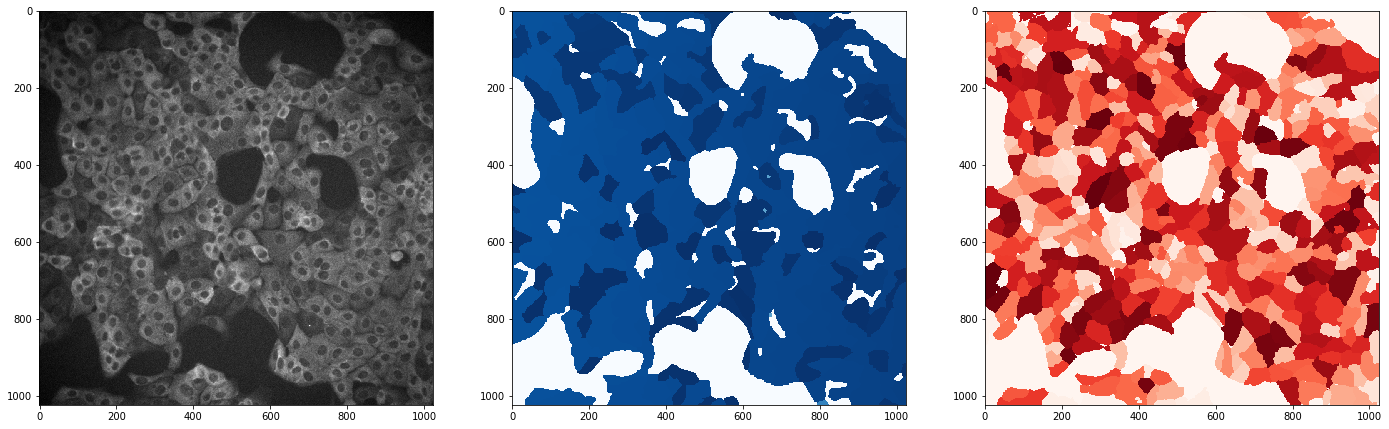

<Figure size 432x288 with 0 Axes>

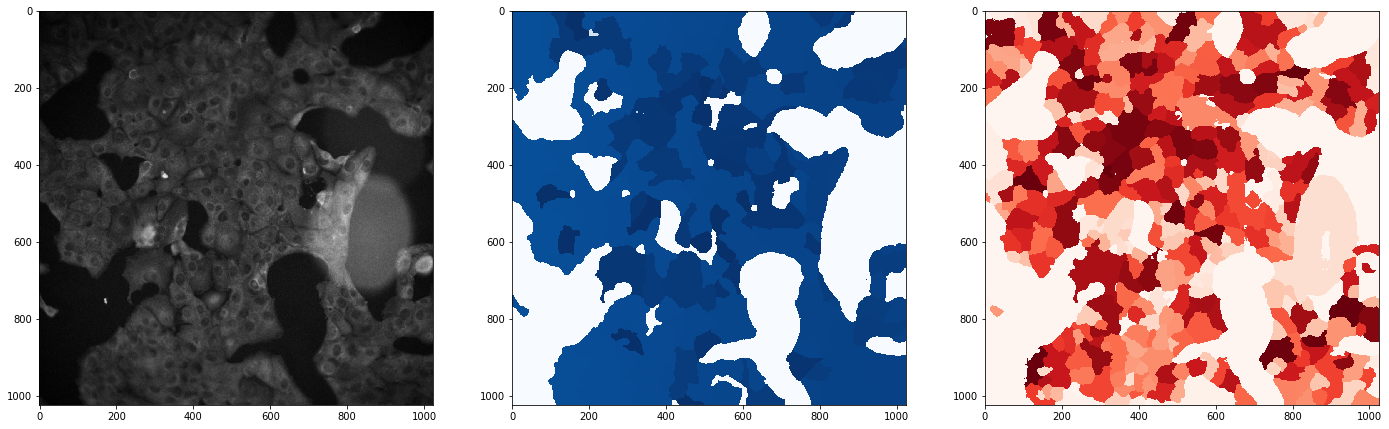

<Figure size 432x288 with 0 Axes>

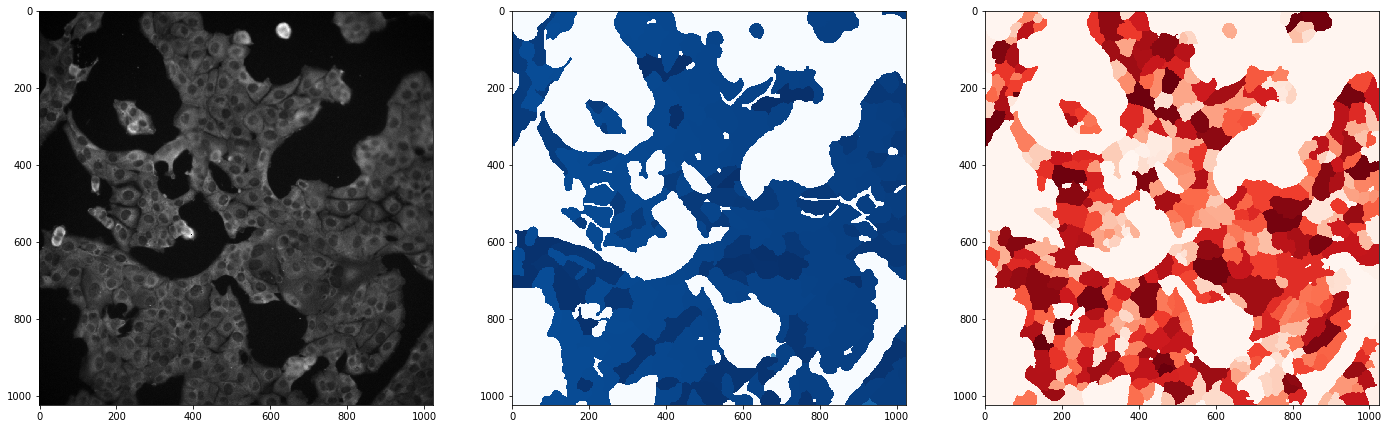

<Figure size 432x288 with 0 Axes>

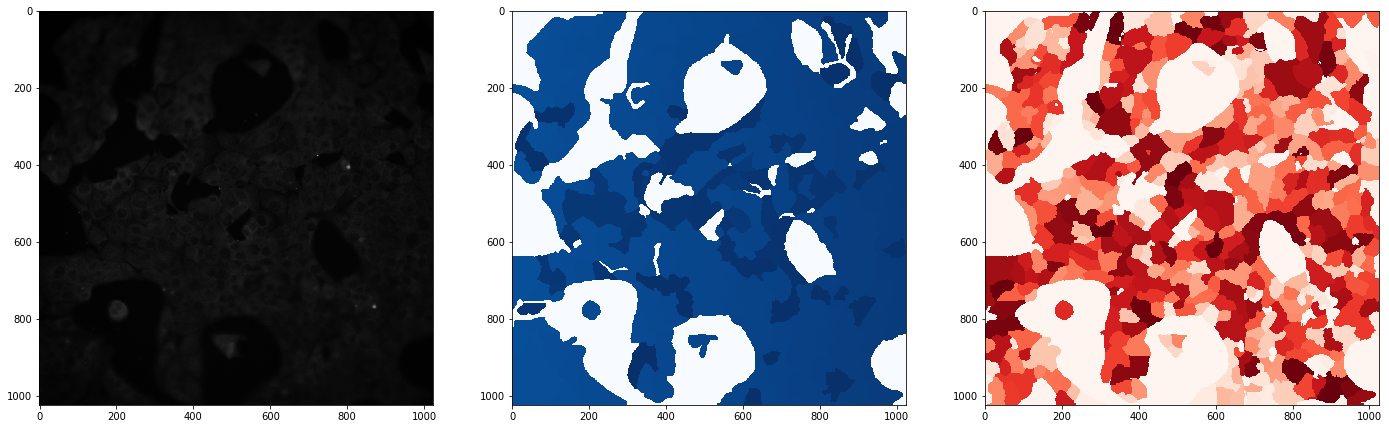

<Figure size 432x288 with 0 Axes>

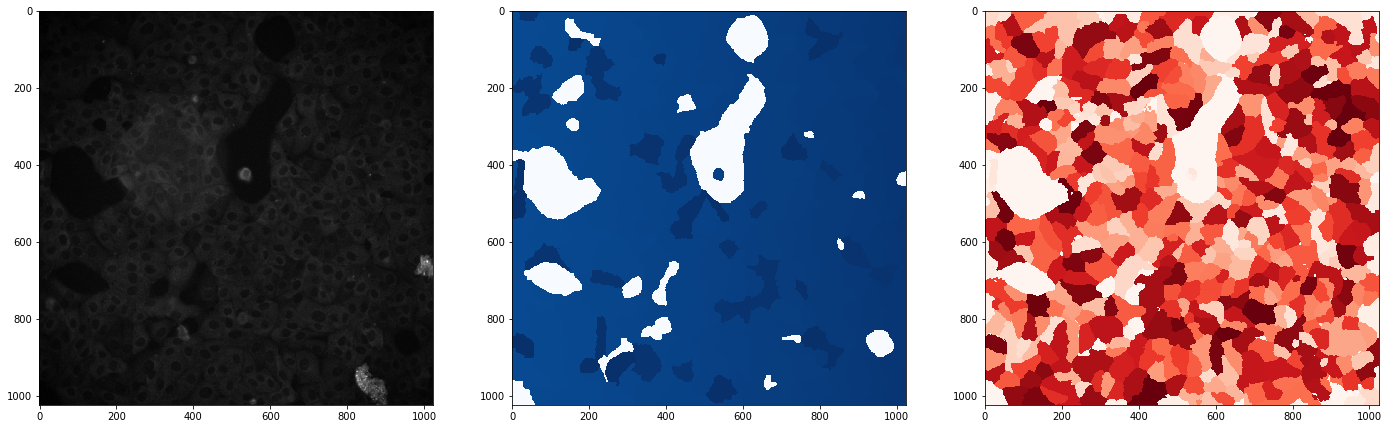

<Figure size 432x288 with 0 Axes>

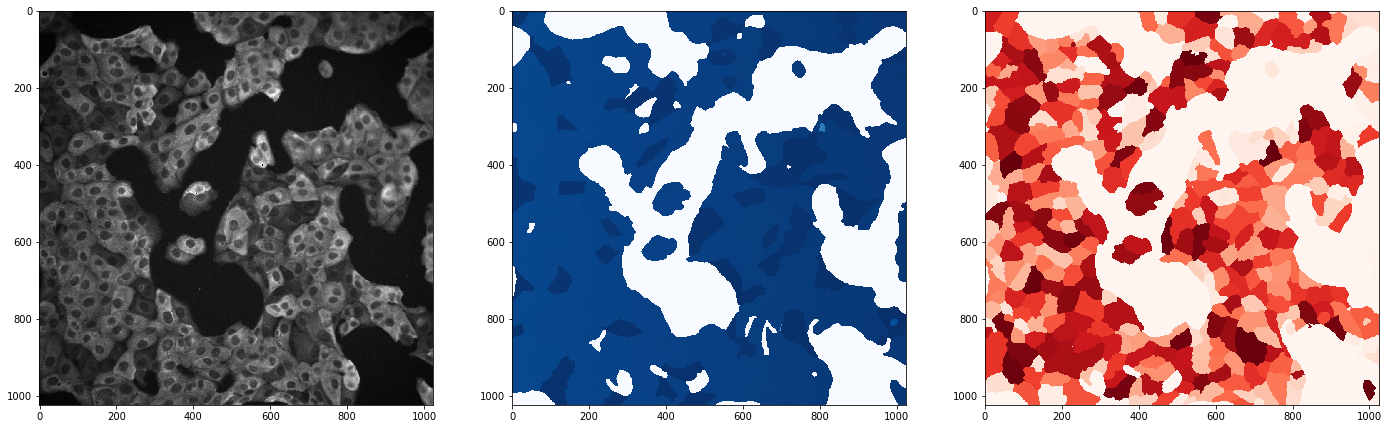

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import h5py
import skimage

filenames = [filename for filename in os.listdir('/content/drive/MyDrive/qbm_data/cell_seg') if filename.endswith("cellseg.tif")]

for filename in filenames:
    with h5py.File('/content/drive/MyDrive/qbm_data/raw/' + filename.split('_cellseg')[0] + '.h5', "r") as f:
        cell_image = f.get('cells').value
        image = f.get('raw').value[0,:,:]
    im = Image.open('/content/drive/MyDrive/qbm_data/cell_seg/' + filename)
    cell_seg = np.array(im)

    plt.figure(figsize=(24,8))
    plt.subplot(1,3,1)
    plt.imshow(image, 'gray', interpolation='none')
    plt.subplot(1,3,2)
    plt.imshow(cell_image, 'Blues', interpolation='none')
    plt.subplot(1,3,3)
    plt.imshow(cell_seg, 'Reds', interpolation='none')
    plt.savefig('/content/drive/MyDrive/qbm_data/result_images/' + filename.split('.tif')[0] + '.png' )
    plt.show()
    plt.clf()
    # plt.imshow(cell_image, cmap='gray')
    # plt.imshow(cell_seg, cmap='Reds', alpha=0.6)
    # plt.axis('off')
    # plt.clf()